<h2 style="font-family: Times New Roman; text-align: center">Legged Locomotion of Robots Labor Project</h2> 
<h3 style="font-family: Times New Roman; text-align: center">Prof. Dr. Koelewijn</h3>
<h4 style="font-family: Times New Roman; text-align: center">Farzam Taghipour (ub21abuq)</h4>
<h4 style="font-family: Times New Roman; text-align: center"><a href="mailto:farzam.taghipour@fau.de">farzam.taghipour@fau.de</a></h4>
<h4 style="font-family: Times New Roman; text-align: center"><a href="https://github.com/FarzamTP/Replicating-Human-Joint-Moments-Using-Neural-Networks">Code in GitHub</a></h4>
<h5 style="font-family: Times New Roman; text-align: center">Winter Semester 23/24</h5>

# Replicating Human Joint Moments Using Neural Networks

## Project Description

* The goal of this project is to compare different input combinations:
    
    1. Only using the joint angle of the joint for which you are creating the controller
    2. All joint angles
    3. Both these options combined with the ground reaction force
    
* The idea is that, if only ***one joint angle*** is sufficient, then less sensors will be required in a prosthesis or exoskeleton, which makes them cheaper and less prone to failure.


## Scientific Questions to Answer

* We want to answer these questions:

    1. Is analyzing a single feature (e.g. Ankle joint angle) is sufficient to predict the joint moment?
    2. How different features are related to each other?
    3. Do we need all features to simulate and predict the joint moment?
    4. How complex models need to be to have a decent performance?
    5. How many paramethers does a neural network should have to perform well?
    6. Does a deep neural network (non-convolutional model) can perform as well as a convolutional neural network?
    7. As data are time-specific, how does recurrent neural networks perform on these data?
    8. Does more paramethers always result to a better performance in above recurrent neural model?
    9. How does long short-term memory networks (LSTM) models perform?
    10. Does a bi-directional neural network model enhance the performance?


# Project Implementation

## Importing Necessary Libraries

* `scipy` to read `mat` files.
* `numpy` to work with arrays.
* `pandas` to convert data into `dataframes`
* `matplotlib` for plotting plots and points.
* `seaborn` to plot heatmaps for correlation matrix.
* `sklearn` to use machine learning algorithms like `LinearRegression` and `DecisionTreeRegressor`
* `Tensorflow` to work with `Keras` to create and train neural networks.
* `datetime` to compute elapsed execution time.

In [60]:
import scipy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from itertools import combinations
from sklearn import svm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from plot_keras_history import show_history, plot_history

## Reading data

* we can use `scipy.io.loadmat` to read and convert `.mat` files into readable `dict` in python.

In [12]:
# Extracting the ankle data from mat file
data_array = scipy.io.loadmat('data/Data_Ankle.mat')['ankle_data']

In [13]:
# Converts the data array into pandas dataframe with corresponding column names
data = pd.DataFrame(data_array, columns=['time', 'vertical_ground_reaction_force',
                                         'trunk_joint_angle', 'hip_joint_angle',
                                         'knee_joint_angle', 'ankle_joint_angle',
                                         'joint_moment'])

In [14]:
# Check if the data is missing
data.isnull().sum()

time                              0
vertical_ground_reaction_force    0
trunk_joint_angle                 0
hip_joint_angle                   0
knee_joint_angle                  0
ankle_joint_angle                 0
joint_moment                      0
dtype: int64

In [15]:
data.head()

,time,vertical_ground_reaction_force,trunk_joint_angle,hip_joint_angle,knee_joint_angle,ankle_joint_angle,joint_moment
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


## Plotting Features

* If we plot the data all together as points, we cannot actually understand the details as there are 48000 dataoints. For this purpose, we should define a time window and plot the data in that time frame.

In [16]:
def plot_feature_per_time(feature_name, title, label, window_size=500):
    """
    Plots given features with their desired label for y-axis, alongside the window-size

    @param feature_name: (str) the feature's name we want to plot w.r.t target `Joint Moment`.
    @param title: (str) the plot's title.
    @param label: (str) the label we want to set for the y-axis.
    @param window_size: (int) the window-size for which we want to plot first data.

    @return: None
    """
    plt.axhline(y=data[feature_name].min(), color='r', linestyle='--', label='Min Angle')
    plt.axhline(y=data[feature_name].max(), color='g', linestyle='--', label='Max Angle')
    
    plt.plot(data.time[:window_size], data[feature_name][:window_size])
    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid()
    plt.show()

### Trunk Joint Angle's Periodic Cycle

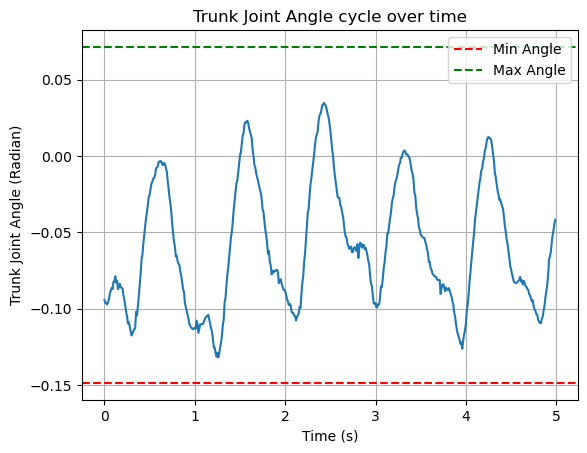

In [17]:
plot_feature_per_time(feature_name='trunk_joint_angle', title='Trunk Joint Angle cycle over time', label='Trunk Joint Angle (Radian)')

### Hip Joint Angle's Periodic Cycle

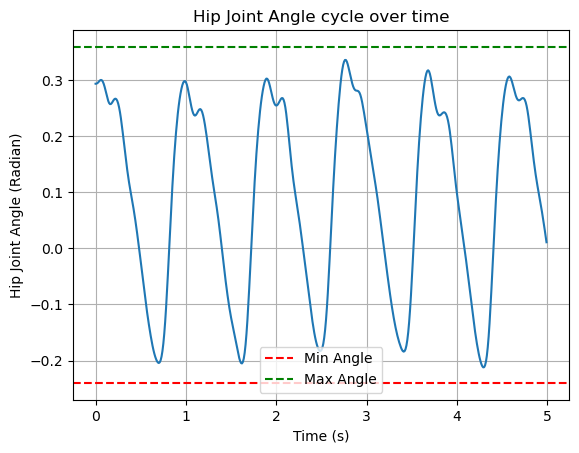

In [18]:
plot_feature_per_time(feature_name='hip_joint_angle', title='Hip Joint Angle cycle over time', label='Hip Joint Angle (Radian)')

### Knee Joint Angle's Periodic Cycle

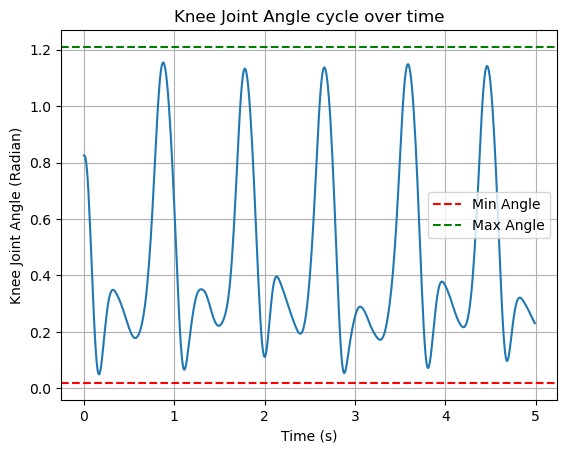

In [19]:
plot_feature_per_time(feature_name='knee_joint_angle', title='Knee Joint Angle cycle over time', label='Knee Joint Angle (Radian)')

### Ankle Joint Angle's Periodic Cycle

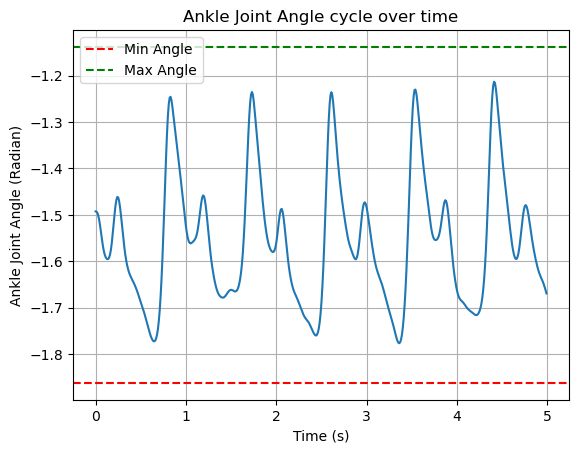

In [20]:
plot_feature_per_time(feature_name='ankle_joint_angle', title='Ankle Joint Angle cycle over time', label='Ankle Joint Angle (Radian)')

### BoxPlot for better understanding

* A Box Plot is the visual representation of the statistical five number summary of a given data set.

      Five Number Summary includes:

    1. Minimum
    2. First Quartile
    3. Median (Second Quartile)
    4. Third Quartile
    5. Maximum


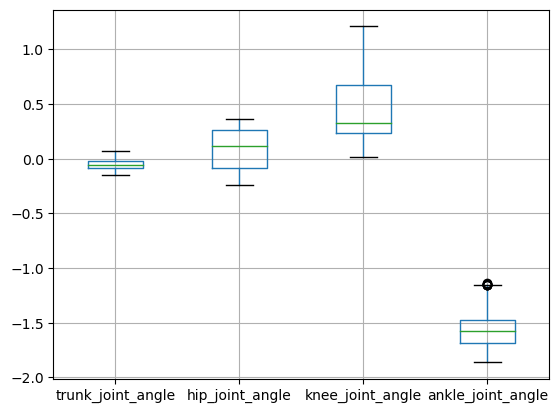

In [21]:
data.boxplot(column=['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle'])
plt.show()

## Normalizing Data
* we can normalize the data using the `MinMaxScaler` method, to make sure selected features have the same range.

In [22]:
columns_to_normalize = ['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle']

normalized_data = data.copy()

normalized_data[columns_to_normalize] = preprocessing.MinMaxScaler().fit_transform(data[columns_to_normalize])
normalized_data.head()

,time,vertical_ground_reaction_force,trunk_joint_angle,hip_joint_angle,knee_joint_angle,ankle_joint_angle,joint_moment
0,0.00,-10.321381,0.246712,0.890431,0.677080,0.510548,-2.011628
1,0.01,-7.990312,0.238134,0.890774,0.674900,0.509714,-3.655209
2,0.02,-6.208738,0.236884,0.892159,0.665259,0.506018,-5.786433
3,0.03,-5.126637,0.233489,0.894766,0.644027,0.497827,-6.190008
4,0.04,-4.774037,0.240635,0.897949,0.610393,0.484816,-5.542868


### Normalized BoxPlot

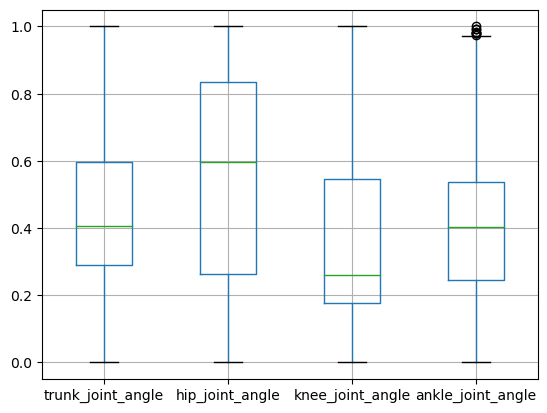

In [23]:
normalized_data.boxplot(column=['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle'])
plt.show()

## Correlation Matrix

* Since the the look periodic, we may assume that some features may be correlated somehow. To test this, we can use the `corr()` method to calculate the correlation between selected features.

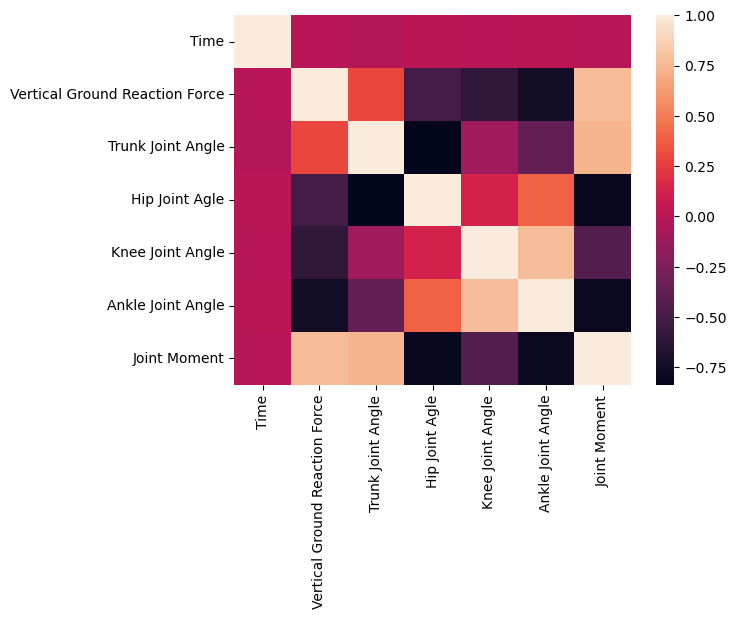

In [24]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

axis_labels = ['Time', 'Vertical Ground Reaction Force', 'Trunk Joint Angle', 'Hip Joint Agle', 'Knee Joint Angle', 'Ankle Joint Angle', 'Joint Moment']

sns.heatmap(corr, xticklabels=axis_labels, yticklabels=axis_labels)

plt.show()

* It can be observed that some features have high correlation with each other (close to 1 or -1). For example, `Trunk Joint Angle` and `Hip Joint Angle` are clearly correlated. To see it better, we can plot them together to see how they behave.

## Plots to Show Correlations

### Hip Joint Angle vs. Trunk Joint Angle

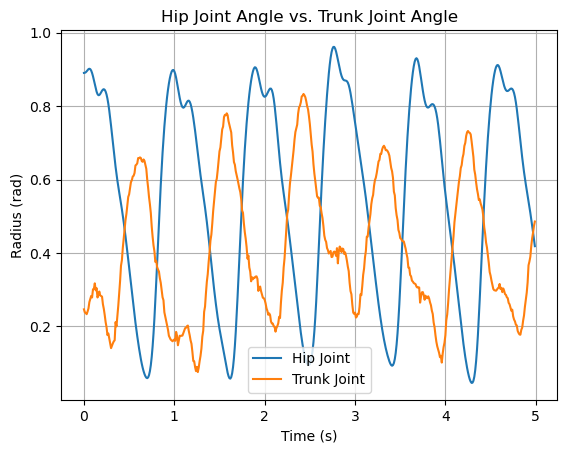

In [25]:
plt.plot(normalized_data.time[:500], normalized_data.hip_joint_angle[:500], label='Hip Joint')
plt.plot(normalized_data.time[:500], normalized_data.trunk_joint_angle[:500], label='Trunk Joint')
plt.title('Hip Joint Angle vs. Trunk Joint Angle')
plt.xlabel('Time (s)')
plt.ylabel('Radius (rad)')
plt.legend()
plt.grid()
plt.show()

* By taking a look at the above plot, we can easily spot that `Hip Joint Angle` and `Trunk Joint Angle` are behaving somehow contradictory.

### Verical Ground Reaction Force vs. Joint Moment

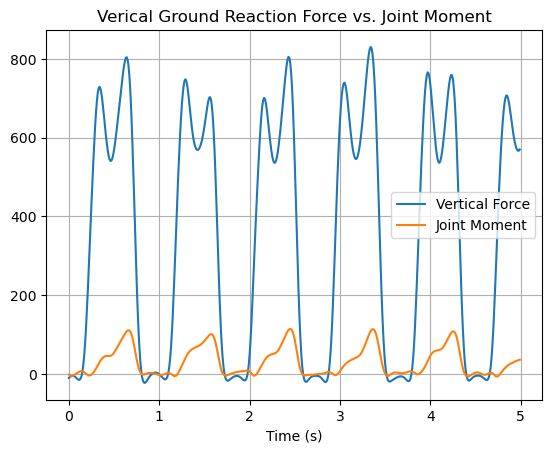

In [26]:
plt.plot(normalized_data.time[:500], normalized_data.vertical_ground_reaction_force[:500], label='Vertical Force')
plt.plot(normalized_data.time[:500], normalized_data.joint_moment[:500], label='Joint Moment')
plt.title('Verical Ground Reaction Force vs. Joint Moment')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

* The same statement can be applied to `Vetical Ground Reaction Force` and `Joint Moment`. They behave the same in the defined time periods, as they rise and fall together.

### Hip Joint Angle vs. Ankle Joint Angle

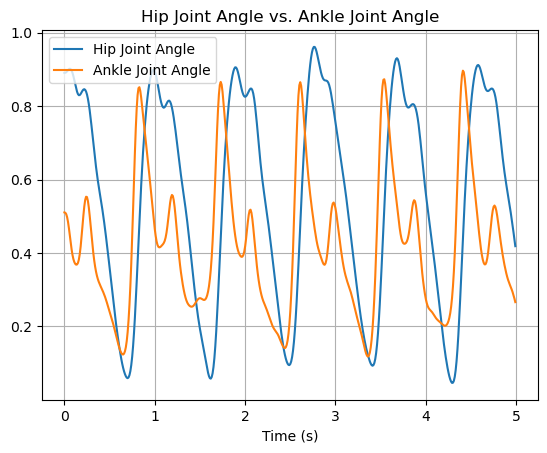

In [27]:
plt.plot(normalized_data.time[:500], normalized_data.hip_joint_angle[:500], label='Hip Joint Angle')
plt.plot(normalized_data.time[:500], normalized_data.ankle_joint_angle[:500], label='Ankle Joint Angle')
plt.title('Hip Joint Angle vs. Ankle Joint Angle')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

* As shown above, there is almost no correlation between `Hip Joint Angle` and `Ankle Joint Angle`.

### Correlation Conclusion

* As shown above, some of the mentioned features are highly correlated and we can omit them for our estimations as they are redundant, and have almost ***no effect*** on the model's performance by training different models with every feature and one time without correlated features.

## PDP Plots

* Partial dependence shows how a particular feature affects a prediction. By making all other features constant, we want to find out how the feature in question influences our outcome.

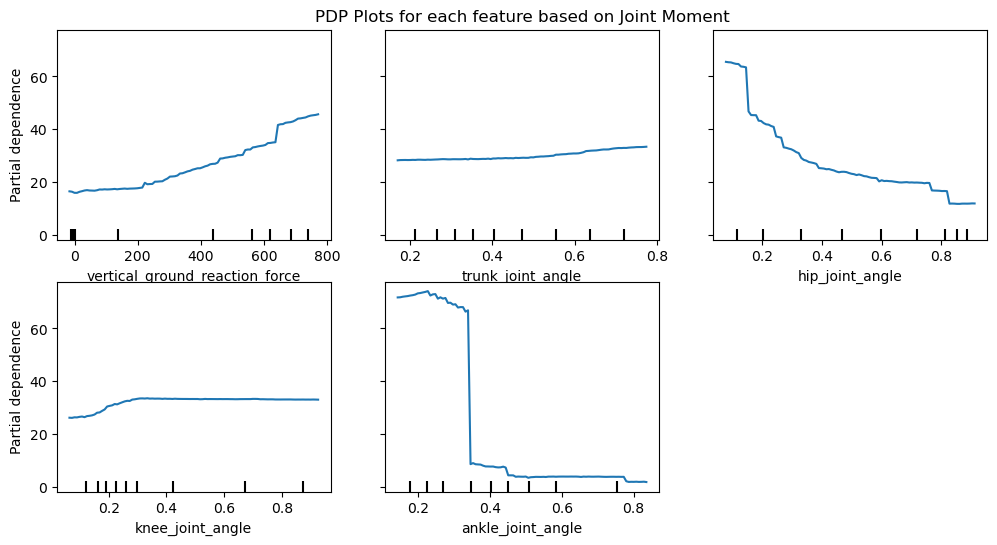

In [28]:
X_normalized = normalized_data.drop(columns=['time', 'joint_moment'])
y = normalized_data.joint_moment

features = X_normalized.columns

clf = DecisionTreeRegressor()

clf.fit(X_normalized, y)

fig, ax = plt.subplots(figsize=(12, 6))

plt.title('PDP Plots for each feature based on Joint Moment')
PartialDependenceDisplay.from_estimator(clf, X_normalized, features, ax=ax)
plt.show()

* When Partial Dependence Plots (PDPs) appear almost continuously horizontal, it generally suggests that the relationship between the predictor variable being examined and the target variable is ***weak*** or ***nearly nonexistent***. In other words, the predictor variable ***does not*** have a significant impact on the target variable, at least within the range of values explored in the PDP.

## ICE Plots

* An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot.

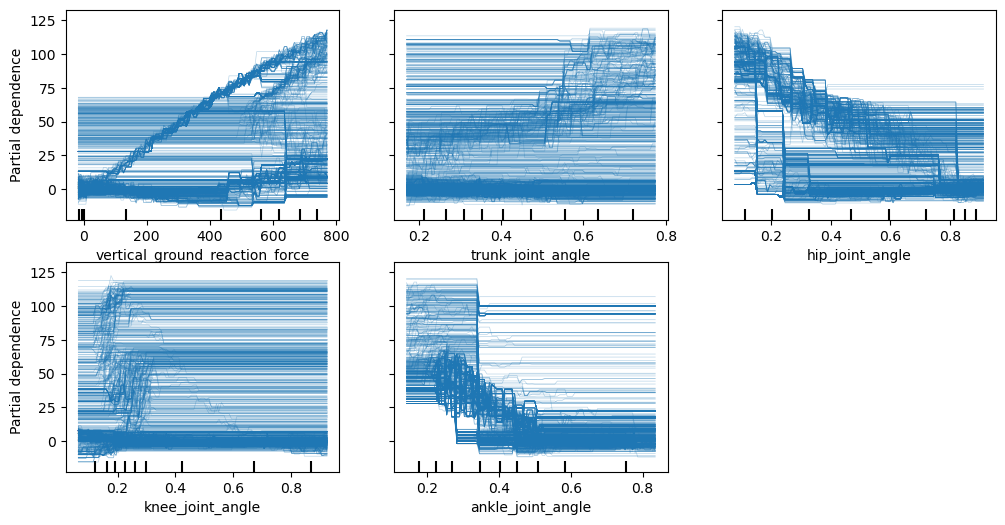

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))

PartialDependenceDisplay.from_estimator(clf, X_normalized, features, ax=ax, kind='individual')
plt.show()

### Importnat Notes Regarding the ICE Plots

![Image](plots/ICE.jpeg)

* As we can see in the above plot, there are some individuals that behave differently with respect to the target feature `Joint Moment`. I interpret these individuals as perturbations in the data.

## Splitting data

In [30]:
X = data.drop(columns=['time', 'joint_moment'])
X_normalized = normalized_data.drop(columns=['time', 'joint_moment'])

y = data.joint_moment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_normalized, y, test_size=0.33, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32160, 5)
y_train shape: (32160,)
X_test shape: (15840, 5)
y_test shape: (15840,)


## Linear Models
    
    1. LinearRregression
    2. DecisionTreeRegressor
    3. RandomForestRegressor
    4. Lasso
    5. Ridge
    6. BayesianRidge

### Linear Regression

In [31]:
LR = LinearRegression()

t0 = datetime.datetime.now()

LR.fit(X_train, y_train)

t1 = datetime.datetime.now()

LR_elapsed_time = (t1 - t0).total_seconds()

LR_score = LR.score(X_test, y_test)

LR.fit(X_train_norm, y_train)

normalized_LR_score = LR.score(X_test_norm, y_test)

print(f"Elapsed Time: {LR_elapsed_time} (s)")
print(f"Linear Regression Score: {LR_score} %, Normalized Data Score: {normalized_LR_score} %")

Elapsed Time: 0.007398 (s)
Linear Regression Score: 0.9525636929396039 %, Normalized Data Score: 0.9525636929396034 %


### Decision Tree Regressor

In [32]:
regression_tree = DecisionTreeRegressor()

t0 = datetime.datetime.now()

regression_tree.fit(X_train, y_train)

t1 = datetime.datetime.now()

decision_tree_elapsed_time = (t1 - t0).total_seconds()

decision_tree_score = regression_tree.score(X_test, y_test)

regression_tree.fit(X_train_norm, y_train)

normalized_regression_tree_score = regression_tree.score(X_test_norm, y_test)

print(f"Elapsed Time: {decision_tree_elapsed_time} (s)")
print(f"Decision Tree Regressor Score: {decision_tree_score} %, Normalized Data Score: {normalized_regression_tree_score} %")

Elapsed Time: 0.217328 (s)
Decision Tree Regressor Score: 0.9825596356429882 %, Normalized Data Score: 0.9824636868955994 %


### Random Forest Regressor

In [33]:
random_forest_regressor = RandomForestRegressor()

t0 = datetime.datetime.now()

random_forest_regressor.fit(X_train, y_train)

t1 = datetime.datetime.now()

random_forest_elapsed_time = (t1 - t0).total_seconds()

random_forest_score = random_forest_regressor.score(X_test, y_test)

random_forest_regressor.fit(X_train_norm, y_train)

normalized_random_forest_score = random_forest_regressor.score(X_test_norm, y_test)

print(f"Elapsed Time: {random_forest_elapsed_time} (s)")
print(f"Random Forest Regressor Score: {random_forest_score} %, Normalized Data Score: {normalized_random_forest_score} %")

Elapsed Time: 10.908615 (s)
Random Forest Regressor Score: 0.9911745193127225 %, Normalized Data Score: 0.9911045548717127 %


### Lasso

In [34]:
lasso = Lasso()

t0 = datetime.datetime.now()

lasso.fit(X_train, y_train)

t1 = datetime.datetime.now()

lasso_elapsed_time = (t1 - t0).total_seconds()

lasso_score = lasso.score(X_test, y_test)

lasso.fit(X_train_norm, y_train)

normalized_lasso_score = lasso.score(X_test_norm, y_test)

print(f"Elapsed Time: {lasso_elapsed_time} (s)")
print(f"Lasso Regressor Score: {lasso_score} %, Normalized Data Score: {normalized_lasso_score} %")

Elapsed Time: 0.008246 (s)
Lasso Regressor Score: 0.815778636210949 %, Normalized Data Score: 0.8860341610619799 %


### Ridge Regressor

In [35]:
ridge = Ridge()

t0 = datetime.datetime.now()

ridge.fit(X_train, y_train)

t1 = datetime.datetime.now()

ridge_elapsed_time = (t1 - t0).total_seconds()

ridge_score = ridge.score(X_test, y_test)

ridge.fit(X_train_norm, y_train)

normalized_ridge_score = ridge.score(X_test_norm, y_test)

print(f"Elapsed Time: {ridge_elapsed_time} (s)")
print(f"Ridge Regressor Score: {ridge_score} %, Normalized Data Score: {normalized_ridge_score} %")

Elapsed Time: 0.010647 (s)
Ridge Regressor Score: 0.9525269914507788 %, Normalized Data Score: 0.952561322978636 %


### Bayesian Ridge

In [36]:
baysian = BayesianRidge()

t0 = datetime.datetime.now()

baysian.fit(X_train, y_train)

t1 = datetime.datetime.now()

baysian_elapsed_time = (t1 - t0).total_seconds()

baysian_score = baysian.score(X_test, y_test)

baysian.fit(X_train_norm, y_train)

normalized_baysian_score = baysian.score(X_test_norm, y_test)

print(f"Elapsed Time: {baysian_elapsed_time} (s)")
print(f"Bayesian Ridge Regressor Score: {baysian_score} %, Normalized Data Score: {normalized_baysian_score} %")

Elapsed Time: 0.017475 (s)
Bayesian Ridge Regressor Score: 0.9525638013341299 %, Normalized Data Score: 0.9525636564293843 %


### Normalization Results

* We can see that normalizing data **mostly** doesn't affect the models' performance except for `Lasso` that increased the score from ~**81.5 %** to ~**88.6 %**. 

## Neural Network

### CNN Model

In [57]:
nn_model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
], name='CnnModel')

In [29]:
nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [30]:
nn_model.summary()

Model: "CnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

In [31]:
t0 = datetime.datetime.now()

nn_history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=4096, verbose=0)

t1 = datetime.datetime.now()

cnn_elapsed_time = (t1 - t0).total_seconds()

In [32]:
print(f"Elapsed Time: {cnn_elapsed_time} (s)")

Elapsed Time: 18.656062 (s)


### Plotting Loss and MSE for CNN

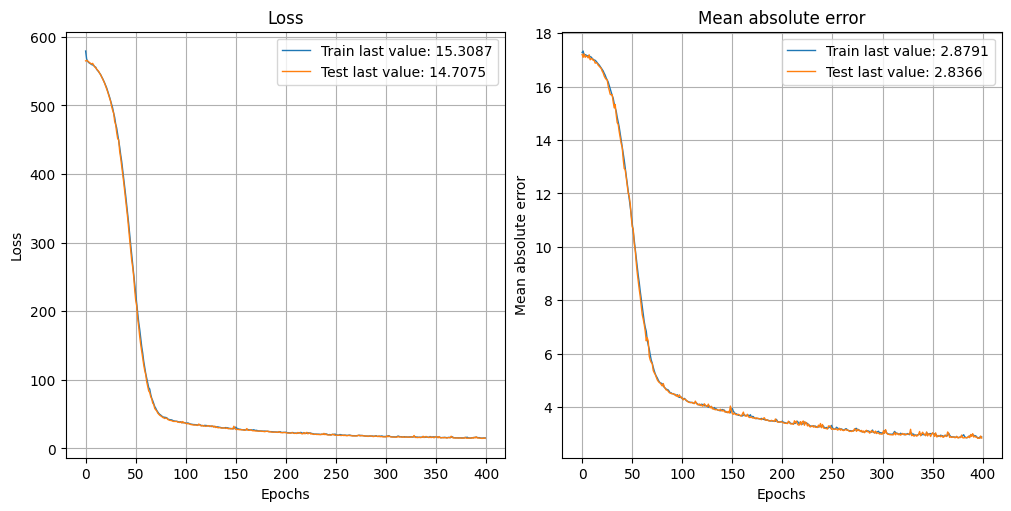

In [33]:
show_history(nn_history)

### RNN Model

In [34]:
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(units=64, activation='relu', input_shape=(5, 1)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')
], name='RnnModel')

In [35]:
rnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [36]:
rnn_model.summary()

Model: "RnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
t0 = datetime.datetime.now()

rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=4096, verbose=0)

t1 = datetime.datetime.now()
rnn_elapsed_time = (t1 - t0).total_seconds()

In [38]:
print(f"Elapsed Time: {rnn_elapsed_time} (s)")

Elapsed Time: 36.036608 (s)


### Plotting Loss and MSE

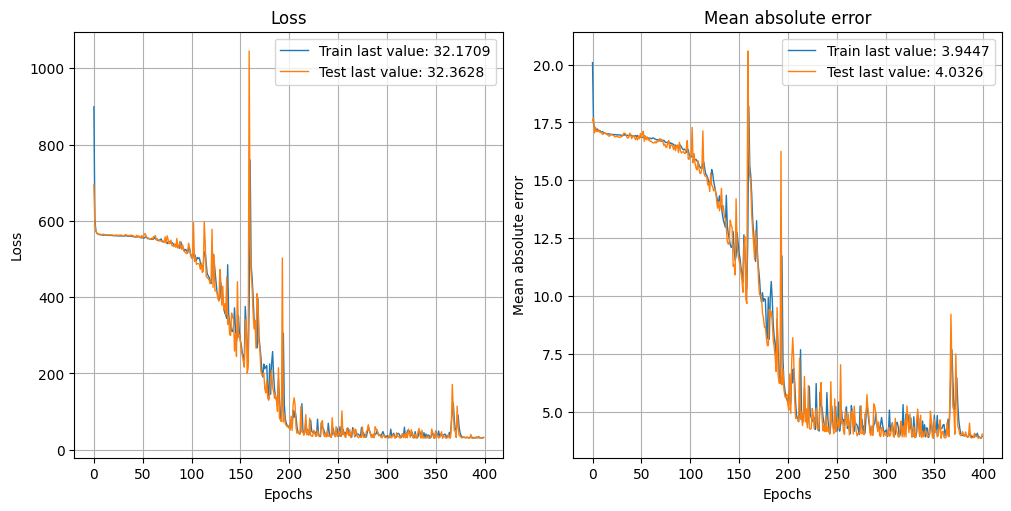

In [39]:
show_history(rnn_history)

### LSTM Model

In [40]:
lstm_model = keras.Sequential([
    keras.layers.LSTM(units=64, return_sequences=True, input_shape=(5, 1)),
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
], name='LSTM_Model')

In [41]:
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [42]:
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 time_distributed (TimeDist  (None, 5, 64)             4160      
 ributed)                                                        
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                20544     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [43]:
t0 = datetime.datetime.now()

lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=4096, verbose=0)

t1 = datetime.datetime.now()
lstm_elapsed_time = (t1 - t0).total_seconds()

In [44]:
print(f"Elapsed Time: {lstm_elapsed_time} (s)")

Elapsed Time: 264.190752 (s)


### Plotting Loss and MSE

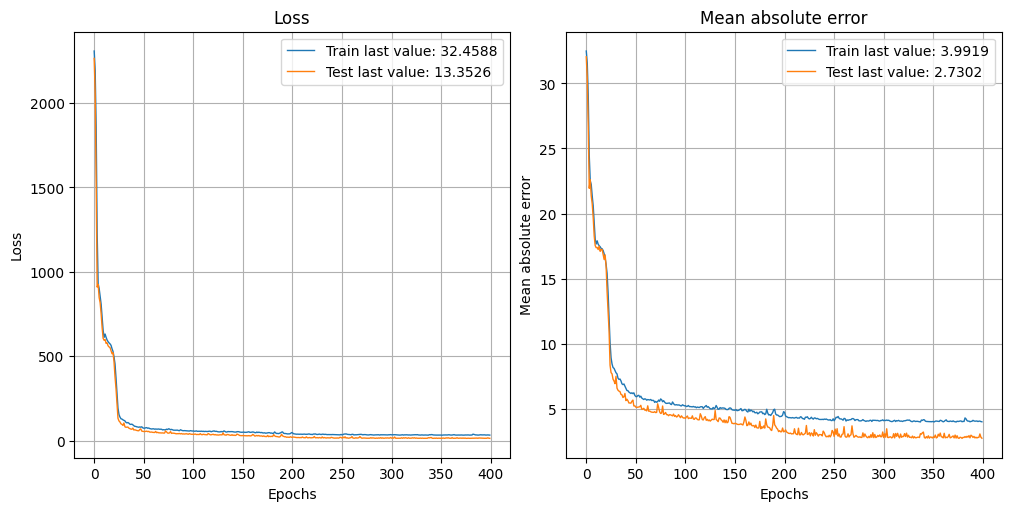

In [45]:
show_history(lstm_history)

### Bi-directional LSTM Model

In [46]:
bi_directional_lstm_model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True), input_shape=(5, 1)),
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True)),
    keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
], name='LSTM_BidirectionalModel')

In [47]:
bi_directional_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [48]:
bi_directional_lstm_model.summary()

Model: "LSTM_BidirectionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 128)            33792     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 128)            98816     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 64)             8256      
 stributed)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                20544     
                                           

In [49]:
t0 = datetime.datetime.now()

bi_directional_lstm_history = bi_directional_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=4096, verbose=0)

t1 = datetime.datetime.now()
bi_directional_lstm_elapsed_time = (t1 - t0).total_seconds()

In [50]:
print(f"Elapsed Time: {bi_directional_lstm_elapsed_time} (s)")

Elapsed Time: 598.464394 (s)


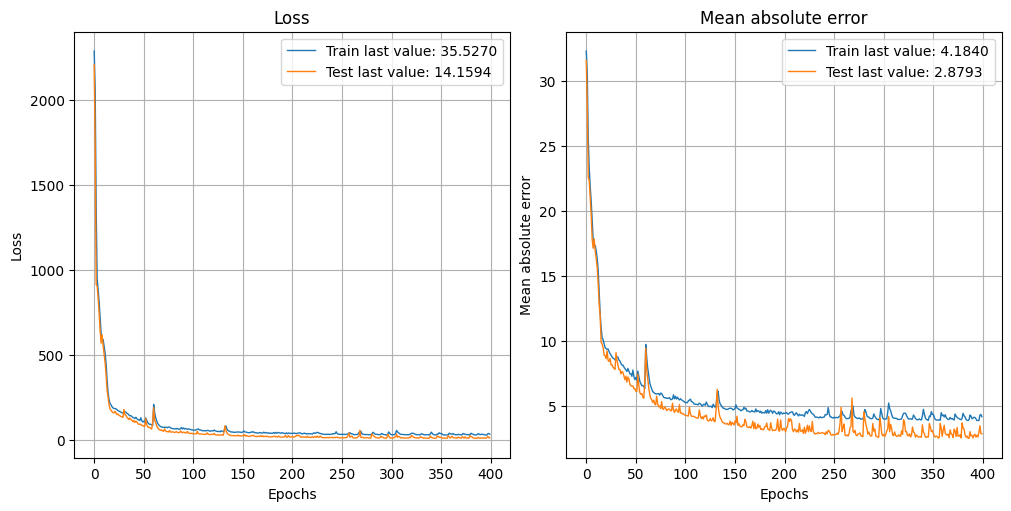

In [51]:
show_history(bi_directional_lstm_history)

## Trainings Results Comparison

* Now that we have all the required trained models, we can compute MSE for each of them and compare their performance on the same test set.

In [56]:
clfs = [LR, regression_tree, random_forest_regressor, lasso, ridge, baysian, nn_model, rnn_model, lstm_model, bi_directional_lstm_model]
elapsed_times = [LR_elapsed_time, decision_tree_elapsed_time, random_forest_elapsed_time, lasso_elapsed_time, ridge_elapsed_time, baysian_elapsed_time, cnn_elapsed_time, rnn_elapsed_time, lstm_elapsed_time, bi_directional_lstm_elapsed_time]
errors = []

for idx, clf in enumerate(clfs):
    prediction = clf.predict(X_test)
    
    error = mean_absolute_error(prediction, y_test)
    elapsed_time = elapsed_times[idx]
    errors.append(error)

495/495 [==============================] - 1s 2ms/step


| Model Name | Mean Square Error | Elapsed Training Time (s) |
| :-: | :-: | :-: |
| LinearRegression | 191.42694082475876 | 0.003315 |
| DecisionTreeRegressor | 37.489920658237 | 0.284153 |
| RandomForestRegressor | 36.78428096079685 | 15.339947 |
| Lasso | 40.313265306818366 | 0.003109 |
| Ridge | 190.807526262169 | 0.009265 |
| BayesianRidge | 191.41289129527775 | 0.014366 |
| CNN Model | 2.836620958920867 | 18.656062 |
| RNN Model | 4.032565727022468 | 36.036608 |
| LSTM Model | 2.7302180064131942 | 264.190752 |
| Bi-directional LSTM Model | 2.8793313654473787 | 598.464394 |

### Comparing Training Times and Losses for Every Model

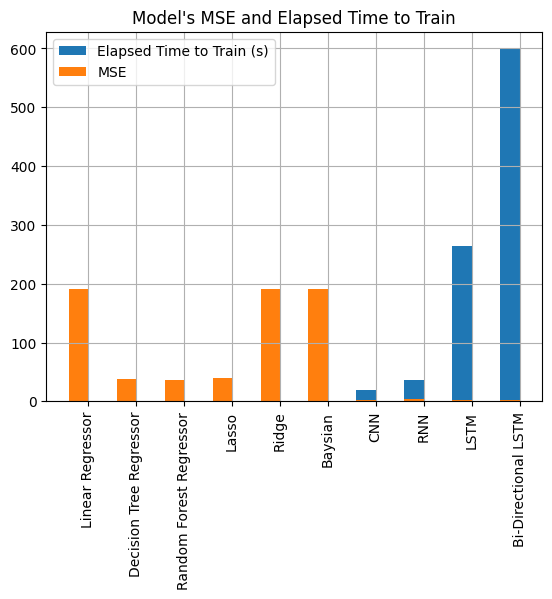

In [55]:
model_names = ['Linear Regressor', 'Decision Tree Regressor', 'Random Forest Regressor', 'Lasso', 'Ridge', 'Baysian', 'CNN', 'RNN', 'LSTM', 'Bi-Directional LSTM']

X_axis = np.arange(len(model_names))

plt.xticks(X_axis, model_names)
plt.xticks(rotation=90)
plt.bar(X_axis - 0.2, elapsed_times, 0.4, label='Elapsed Time to Train (s)')
plt.title('Model\'s MSE and Elapsed Time to Train')
plt.xticks(X_axis, model_names)
plt.bar(X_axis - 0.2, errors, 0.4, label='MSE')
plt.grid(True)
plt.legend()
plt.show()

## Model Performance Conclusion over All Features

* Based on the analysis, we can conclude that Neural Networks (specifically speaking Recurrent Neural Networks) perform significantly better on the data. However, training neural networks, especially LSTM model, takes significantly longer than linear models. For this purpose, below notes can be conducted:

    1. We can use `CNN models`, as they dont't require long training times, and they are precise.
    2. if we want to insist on **importance of time-series** in the data, we can use `RNN` models, which require **short training times**, and perform as well as `LSTM` models, and they don't  take long time to train.
    3. If the training time is **important**, and we **don't mind** using **non-neural network** models, we may use `RandomForestRegressor`, `DecisionTreeRegressor`, or `Lasso` accordingly.
    4. `Bi-directional LSTM` model has `no advantage` over `LSTM` model. Furthermore, it's training time is almost **twice** as `LSTM` model. Consequently, we can accept that the data has **no bi-directional** properties.
 
* As now we know which model performs the best over all five features, we need to answer the question: **What is the smallest number of features we need to have a decent performance?**
* Smaller feature space means that we need less sensors to gather data, which leads to cheaper prosthesis.

## Feature Space Selection

* Based on the above analysis, we will now select different sub-spaces of our feature space to check which combined features perform as well as all features combined?

### Feature space containing only One Feature

#### Only One Feature with DecisionTreeRegressor

In [82]:
feature_names = ['vertical_ground_reaction_force', 'trunk_joint_angle',	'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle']
single_feature_errors = []

for feature_name in feature_names:
    
    X_one_feature = normalized_data[str(feature_name)].to_numpy().reshape(-1, 1)
    y_one_feature = normalized_data.joint_moment
    
    X_train_one_feature, X_test_one_feature, y_train_one_feature, y_test_one_feature = train_test_split(X_one_feature, y_one_feature, test_size=0.33, random_state=42)
    
    regressor = DecisionTreeRegressor()
    
    regressor.fit(X_train_one_feature, y_train_one_feature)
    
    prediction = regressor.predict(X_test_one_feature)
    
    mse = mean_absolute_error(prediction, y_test_one_feature)
    
    single_feature_errors.append(mse)

| Feature Name | Mean Square Error |
| :-: | :-: |
| Vertical Ground Reaction Force | 20.745292548520855 |
| Trunk Joint Angle | 21.34414962131895 | 
| Hip Joint Angle | 19.70776012473898 |
| Knee Joint Angle | 25.92375091658054 |
| Ankle joint Angle | 14.111932897082209 |

### Feature space containing Two Feature

### Pair Selector Function

* We need a function to return us every pair of features to analyze.

In [83]:
def generate_pairs(input_array):
    # Initialize an empty list to store pairs
    pairs = []

    # Use nested loops to create pairs of elements
    for i in range(len(input_array)):
        for j in range(i + 1, len(input_array)):
            pair = [input_array[i], input_array[j]]
            pairs.append(pair)

    return pairs

In [84]:
pairs = generate_pairs(feature_names)
pair_errors = []

for pair in pairs:
    
    X_two_feature = normalized_data[pair].to_numpy()

    y_two_feature = normalized_data.joint_moment
    
    X_train_two_feature, X_test_two_feature, y_train_two_feature, y_test_two_feature = train_test_split(X_two_feature, y_two_feature, test_size=0.33, random_state=42)
    
    regressor = DecisionTreeRegressor()
    
    regressor.fit(X_train_two_feature, y_train_two_feature)
    
    prediction = regressor.predict(X_test_two_feature)
    
    mse = mean_absolute_error(prediction, y_test_two_feature)
    
    pair_errors.append(mse)

| Feature 1 | Feature 2 | Mean Square Error |
| :-: | :-: | :-: |
| Vertical Ground Reaction Force | Trunk Joint Angle | 7.178059941631315 |
| Vertical Ground Reaction Force | Hip Joint Angle | 5.411830813820987 |
| Vertical Ground Reaction Force | Knee Joint Angle | 11.28008864202483 |
| Vertical Ground Reaction Force | Ankle Joint Angle | 8.105619084272801 |
| Trunk Joint Angle | Hip Joint Angle | 15.16507215852817 | 
| Trunk Joint Angle | Knee Joint Angle | 9.764600256311368 | 
| Trunk Joint Angle | Ankle Joint Angle | 7.855781722616615 | 
| Hip Joint Angle | Knee Joint Angle | 5.388404760784376 |
| Hip Joint Angle | Ankle Joint Angle | 6.508475675896628 |
| Knee Joint Angle | Ankle Joint Angle | 10.894176677447074 |

### Feature space containing Three Feature

In [85]:
def generate_triples(input_array):
    # Use itertools.combinations to generate all combinations of 3 elements
    triples = list(combinations(input_array, 3))
    return triples

In [86]:
triples = generate_triples(feature_names)
triples_errors = []

for triple in triples:
    triple = list(triple)
    
    X_three_feature = normalized_data[triple].to_numpy()

    y_three_feature = normalized_data.joint_moment
    
    X_train_three_feature, X_test_three_feature, y_train_three_feature, y_test_three_feature = train_test_split(X_three_feature, y_three_feature, test_size=0.33, random_state=42)
    
    regressor = DecisionTreeRegressor()
    
    regressor.fit(X_train_three_feature, y_train_three_feature)
    
    prediction = regressor.predict(X_test_three_feature)
    
    mse = mean_absolute_error(prediction, y_test_three_feature)
    
    triples_errors.append(mse)

| Feature 1 | Feature 2 | Feature 3 | Mean Square Error |
| :-: | :-: | :-: | :-: |
| Vertical Ground Reaction Force | Trunk Joint Angle | Hip Joint Angle | 4.851509693009391 |
| Vertical Ground Reaction Force | Trunk Joint Angle | Knee Joint Angle | 5.296384786470117 |
| Vertical Ground Reaction Force | Trunk Joint Angle | Ankle Joint Angle | 5.610839021495343 |
| Vertical Ground Reaction Force | Hip Joint Angle | Knee Joint Angle | 4.30000954161124 |
| Vertical Ground Reaction Force | Hip Joint Angle | Ankle Joint Angle | 4.670558354324991 |
| Vertical Ground Reaction Force | Knee Joint Angle | Ankle Joint Angle | 5.249182548795679 |
| Trunk Joint Angle | Hip Joint Angle | Knee Joint Angle | 4.662134572349286 | 
| Trunk Joint Angle | Hip Joint Angle | Ankle Joint Angle | 5.394411851185054 | 
| Trunk Joint Angle | Knee Joint Angle | Ankle Joint Angle | 6.036280521456228 | 
| Hip Joint Angle | Knee Joint Angle | Ankle Joint Angle | 4.803126949321675 |


### Feature space containing Four Feature

In [87]:
def generate_quadruples(input_array):
    # Use itertools.combinations to generate all combinations of 4 elements
    quadruples = list(combinations(input_array, 4))
    return quadruples

In [88]:
quadruples = generate_quadruples(feature_names)
quadruples_errors = []

for quadruple in quadruples:
    quadruple = list(quadruple)
    
    X_four_feature = normalized_data[quadruple].to_numpy()

    y_four_feature = normalized_data.joint_moment
    
    X_train_four_feature, X_test_four_feature, y_train_four_feature, y_test_four_feature = train_test_split(X_four_feature, y_four_feature, test_size=0.33, random_state=42)
    
    regressor = DecisionTreeRegressor()
    
    regressor.fit(X_train_four_feature, y_train_four_feature)
    
    prediction = regressor.predict(X_test_four_feature)
    
    mse = mean_absolute_error(prediction, y_test_four_feature)
    
    quadruples_errors.append(mse)

| Feature 1 | Feature 2 | Feature 3 | Feature 4 | Mean Square Error |
| :-: | :-: | :-: | :-: | :-: |
| Vertical Ground Reaction Force | Trunk Joint Angle | Hip Joint Angle | Knee Joint Angle | 3.6819554078908934 |
| Vertical Ground Reaction Force | Trunk Joint Angle | Hip Joint Angle | Ankle Joint Angle | 4.245834202771391 |
| Vertical Ground Reaction Force | Trunk Joint Angle | Knee Joint Angle | Ankle Joint Angle | 4.41575004910883 |
| Vertical Ground Reaction Force | Hip Joint Angle | Knee Joint Angle | Ankle Joint Angle | 4.074960649347516 |
| Trunk Joint Angle | Hip Joint Angle | Knee Joint Angle | Ankle Joint Angle | 4.184786121519491 | 

### Feature space containing All Five Feature

In [89]:
X_all_feature = normalized_data.drop(columns=['joint_moment']).to_numpy()

y_all_feature = normalized_data.joint_moment

X_train_all_feature, X_test_all_feature, y_train_all_feature, y_test_all_feature = train_test_split(X_all_feature, y_all_feature, test_size=0.33, random_state=42)

regressor = DecisionTreeRegressor()

regressor.fit(X_train_all_feature, y_train_all_feature)

prediction = regressor.predict(X_test_all_feature)

all_feature_error = mean_absolute_error(prediction, y_test_all_feature)

| Feature 1 | Feature 2 | Feature 3 | Feature 4 | Feature 5 | Mean Square Error |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Vertical Ground Reaction Force | Trunk Joint Angle | Hip Joint Angle | Knee Joint Angle | Ankle Joint Angle | 3.5158019936705047 |

### Features Subset Selection Conclusion

* Best selections in each subset are listed below:


| Subset | Mean Square Error |
| :-: | :-: | 
| Ankle joint Angle | 14.111932897082209 |
| **Vertical Ground Reaction Force & Hip Joint Angle** | **5.411830813820987** |
| **Hip Joint Angle & Knee Joint Angle** | **5.388404760784376** |
| Vertical Ground Reaction Force & Hip Joint Angle & Knee Joint Angle | 4.30000954161124 |
| Vertical Ground Reaction Force & Trunk Joint Angle & Hip Joint Angle & Knee Joint Angle | 3.6819554078908934 |
| All Features | 3.5158019936705047 |

* Obviously the subset with all features has the lowest MSE. However, it can be seen that we can reach a great performance by using only **two** features instead of all five.
    
    1. **`Vertical Ground Reaction Force`** & **`Hip Joint Angle`**
    2. **`Hip Joint Angle`** & **`Knee Joint Angle`**
    

### **Note**:
* We can see that **`Hip Joint Angle`** appears in best subsets almost everytime. It is related to the fact that according to the correlation matrix, it has a **very high** correlation with `Joint Moment`.


![Annotated Matrix](plots/corr-matrix-annotated.jpeg)